# Bayesian Personalized Ranking (BPR-OPT): Experiments and Evaluation

This notebook implements Bayesian Personalized Ranking method.

This method learns relative preferences of users and does it with pairwise loss: for each user two items are chosen, one with some interaction is considered positive and second is the one, that user haven't seen, is considered negative. 3 strategies to choose these negative examples are suggested and tested: uniform negatives, popularity-based negatives (more popular items are sampled more often) and mixed.

Each combination user-positive and user-negative is scored via dot product with bias. As positive pair should have higher score than negative, difference $x_{upn} = s(u_p) - s(u_n)$ should be positive. BPR uses a logistic probability that the ordering is correct via sigmoid, so optimization objective is to minimize negative log-likelihood: $\mathcal{L}_{uij} = -\log \sigma(x_{upn})$. L2-regularization is used for embeddings matrices representing users and items and biases, so that the model doesn't overfit.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig, add_random_timestamps, UserTemporalSplitConfig
from src.models import BPRMF, BPRConfig, UniformNegativeSampler, PopularityNegativeSampler, MixedNegativeSampler
from src.evaluation import (
    EvaluationPipeline,
    print_evaluation_results,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

For this task temporal split we use differs from similarity recommendation algorithms. If we split by the year the book was published, matrix factorization inherently make no sense, as all of the validation and test books will face cold start problem. Therefore we create random variable timestamp, that simulates time the book was rated. Then, for each user we order ratings by timestamp and split train/val/test with 0.7/0.15/0.15 ratio, so that older books go in train and newer into validation and test. This creates simulation of temporal data.

In [2]:
# Load data
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp")



In [3]:
import re
import pandas as pd

# -----------------------
# 1) Canonicalizers (string-level)
# -----------------------
def canon_text(s: str) -> str:
    if s is None or (isinstance(s, float) and pd.isna(s)) or pd.isna(s):
        return ""
    s = str(s).lower()

    # remove edition/format noise in (...) or [...]
    s = re.sub(r"\([^)]*\)", " ", s)
    s = re.sub(r"\[[^\]]*\]", " ", s)

    # remove punctuation
    s = re.sub(r"[^a-z0-9\s]+", " ", s)

    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s


# -----------------------
# 2) Build canonical ISBN mapping using only (title, author)
# -----------------------
def build_canonical_isbn_map(books: pd.DataFrame) -> pd.DataFrame:
    """
    books columns: isbn, title, author, year, publisher (year/publisher ignored)
    returns mapping with:
      original_isbn, isbn(new canonical), canon_title, canon_author, canon_key
    """
    b = books.copy().rename(columns={"isbn": "original_isbn"})

    b["canon_title"] = b["title"].map(canon_text)
    b["canon_author"] = b["author"].map(canon_text)

    # canonical key: only title + author
    b["canon_key"] = b["canon_title"] + "||" + b["canon_author"]

    # create stable integer ids per canonical key
    codes, uniques = pd.factorize(b["canon_key"], sort=True)
    b["isbn"] = (codes + 1).astype("int64")  # new canonical "isbn"

    # keep one row per original isbn (in case of duplicates)
    mapping = b[["original_isbn", "isbn", "canon_title", "canon_author", "canon_key"]].drop_duplicates("original_isbn")
    return mapping


# -----------------------
# 3) Apply mapping to ratings and rename columns
# -----------------------
def merge_canonical_isbn_to_ratings(
    ratings: pd.DataFrame,
    mapping: pd.DataFrame,
    ratings_isbn_col: str = "isbn",
) -> pd.DataFrame:
    """
    ratings columns: userId, isbn, rating, timestamp (or similar)
    mapping: output of build_canonical_isbn_map
    Output:
      - ratings has original isbn preserved as 'original_isbn'
      - ratings has new canonical isbn in column 'isbn'
    """
    r = ratings.copy().rename(columns={ratings_isbn_col: "original_isbn"})

    r = r.merge(mapping[["original_isbn", "isbn"]], on="original_isbn", how="left")

    # optional: if some ISBNs in ratings are missing from books/mapping
    # keep them as their own canonical ids (or drop)
    missing = r["isbn"].isna()
    if missing.any():
        # assign new ids after existing max
        start = int(mapping["isbn"].max()) + 1 if len(mapping) else 1
        r.loc[missing, "isbn"] = range(start, start + missing.sum())
    r["isbn"] = r["isbn"].astype("int64")

    return r


# -----------------------
# Example usage
# -----------------------
# books_df: columns [isbn, title, author, year, publisher]
# ratings_df: columns [userId, isbn, rating, timestamp]

mapping_df = build_canonical_isbn_map(books)
ratings_canon = merge_canonical_isbn_to_ratings(ratings_ts, mapping_df)

# Now:
# - books_df still unchanged
# - mapping_df has original_isbn -> new isbn
# - ratings_canon has columns: original_isbn (old), isbn (new), plus userId/rating/timestamp


def add_canonical_isbn_to_books(books_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input columns: isbn, title, author, year, publisher
    Output: same df but
      - old 'isbn' renamed to 'original_isbn'
      - new integer 'isbn' created from canonicalized (title, author)
    """
    b = books_df.copy()

    # rename old isbn
    b = b.rename(columns={"isbn": "original_isbn"})

    # canonical key from title + author only
    canon_title = b["title"].map(canon_text)
    canon_author = b["author"].map(canon_text)
    canon_key = canon_title + "||" + canon_author

    # stable integer ids per canonical key
    codes, _ = pd.factorize(canon_key, sort=True)
    b["isbn"] = (codes + 1).astype("int64")   # new canonical "isbn"

    return b

# usage:
books = add_canonical_isbn_to_books(books)

In [4]:
ratings_ts = ratings_canon
ratings_ts['isbn'] = ratings_canon['isbn'].astype('string')
books['isbn'] = books['isbn'].astype('string')
mapping_df['isbn'] = mapping_df['isbn'].astype('string')

In [5]:
# Initialize evaluation pipeline
K_VALUES = [10]
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)

# Store all results
all_results = {}

## 2. BPR-OPT

In [6]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)


train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)
test_df = pd.concat([test_df, val_df], axis=0, ignore_index=True)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 926,140 ratings
Iteration 1: 586,031 ratings, 14,951 users, 7,988 items
Iteration 2: 567,215 ratings, 12,562 users, 7,596 items
Iteration 3: 566,560 ratings, 12,500 users, 7,577 items
Iteration 4: 566,534 ratings, 12,498 users, 7,576 items
Iteration 5: 566,517 ratings, 12,497 users, 7,575 items
Iteration 6: 566,517 ratings, 12,497 users, 7,575 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 391,144 ratings
  Val: 78,646 ratings
  Test: 96,727 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train           391,144     12,497      7,559       1904-2004         7.95
val              78,646     12,497      6,044       1904-2004     

In [7]:
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 7,559
Test items: 7,223
Overlap (items in both): 7207

Shared users (in both train and test): 12,497
Test-only users: 0


In [8]:
from typing import Dict, List, Tuple, Optional
def make_id_maps(df: pd.DataFrame, user_col="user_id", item_col="isbn") -> Tuple[Dict, Dict, np.ndarray, np.ndarray]:
    users = df[user_col].unique()
    items = df[item_col].unique()
    user2idx = {u: k for k, u in enumerate(users)}
    item2idx = {i: k for k, i in enumerate(items)}
    idx2user = users
    idx2item = items
    return user2idx, item2idx, idx2user, idx2item


def build_user_positives(
    df: pd.DataFrame,
    user2idx: Dict,
    item2idx: Dict,
    user_col="user_id",
    item_col="isbn",
    rating_col="rating",
    min_rating_pos: int = 1,
) -> List[np.ndarray]:
    """
    For each user index, store an array of positive item indices.
    Positives: rating >= min_rating_pos (default: >0, i.e., explicit positives in Book-Crossing).
    """
    n_users = len(user2idx)
    pos_lists: List[List[int]] = [[] for _ in range(n_users)]
    sub = df[df[rating_col] >= min_rating_pos][[user_col, item_col]].drop_duplicates()

    for u, i in sub.itertuples(index=False):
        if u in user2idx and i in item2idx:
            pos_lists[user2idx[u]].append(item2idx[i])

    return [np.asarray(lst, dtype=np.int32) for lst in pos_lists]


def build_seen_sets(
    df: pd.DataFrame,
    user2idx: Dict,
    item2idx: Dict,
    user_col="userId",
    item_col="itemId",
) -> List[set]:
    """Items seen in train (for filtering during recommend)."""
    n_users = len(user2idx)
    seen = [set() for _ in range(n_users)]
    sub = df[[user_col, item_col]].drop_duplicates()
    for u, i in sub.itertuples(index=False):
        if u in user2idx and i in item2idx:
            seen[user2idx[u]].add(item2idx[i])
    return seen


def train_bpr_on_bookcrossing(
    train_df: pd.DataFrame,
    user_col="user_id",
    item_col="isbn",
    rating_col="rating",
    timestamp_col="timestamp",
    min_rating_pos: int = 1,  
    neg_strategy: str = "mixed",  # "uniform" | "pop" | "mixed"
    pop_alpha: float = 1.0,
    mixed_p_uniform: float = 0.5,
    cfg: Optional[BPRConfig] = None,
) -> Tuple[BPRMF, Dict, Dict, np.ndarray, np.ndarray, List[np.ndarray], List[set]]:
    """
    Returns:
      model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen
    """
    cfg = cfg or BPRConfig()

    user2idx, item2idx, idx2user, idx2item = make_id_maps(train_df, user_col, item_col)

    n_users = len(user2idx)
    n_items = len(item2idx)

    user_pos = build_user_positives(train_df, user2idx, item2idx, user_col, item_col, rating_col, min_rating_pos)
    user_seen = build_seen_sets(train_df, user2idx, item2idx, user_col, item_col)

    tmp = train_df[[user_col, item_col]].drop_duplicates()
    pop_counts = tmp[item_col].map(item2idx).value_counts().reindex(range(n_items), fill_value=0).values

    rng = np.random.default_rng(cfg.seed)
    uniform = UniformNegativeSampler(n_items, rng)
    pop = PopularityNegativeSampler(pop_counts, rng, alpha=pop_alpha)

    if neg_strategy == "uniform":
        sampler = uniform
    elif neg_strategy == "pop":
        sampler = pop
    elif neg_strategy == "mixed":
        sampler = MixedNegativeSampler(uniform, pop, p_a=mixed_p_uniform, rng=rng)
    else:
        raise ValueError("neg_strategy must be one of: 'uniform', 'pop', 'mixed'")

    model = BPRMF(n_users, n_items, cfg)
    losses_train, ndcgs, precisions, hit_rates = model.fit(user_pos=user_pos, neg_sampler=sampler, verbose=True, val_df = test_df, 
        train_df = train_df,
        user2idx = user2idx, 
        idx2item = idx2item, 
        item2idx = item2idx)
    

    return model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates


### Uniform negatives sampling

In [13]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=50,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="uniform",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/50 | train_bpr_loss=0.46844
Epoch 02/50 | train_bpr_loss=0.36680
Epoch 03/50 | train_bpr_loss=0.32737
Epoch 04/50 | train_bpr_loss=0.29328
Epoch 05/50 | train_bpr_loss=0.26593
Epoch 06/50 | train_bpr_loss=0.23782
Epoch 07/50 | train_bpr_loss=0.21128
Epoch 08/50 | train_bpr_loss=0.18720
Epoch 09/50 | train_bpr_loss=0.16739
Epoch 10/50 | train_bpr_loss=0.15011
Epoch 11/50 | train_bpr_loss=0.13345
Epoch 12/50 | train_bpr_loss=0.12067
Epoch 13/50 | train_bpr_loss=0.10887
Epoch 14/50 | train_bpr_loss=0.09883
Epoch 15/50 | train_bpr_loss=0.09072
Epoch 16/50 | train_bpr_loss=0.08289
Epoch 17/50 | train_bpr_loss=0.07664
Epoch 18/50 | train_bpr_loss=0.07071
Epoch 19/50 | train_bpr_loss=0.06587
Epoch 20/50 | train_bpr_loss=0.06099
Epoch 21/50 | train_bpr_loss=0.05712
Epoch 22/50 | train_bpr_loss=0.05364
Epoch 23/50 | train_bpr_loss=0.05021
Epoch 24/50 | train_bpr_loss=0.04782
Epoch 25/50 | train_bpr_loss=0.04551
Epoch 26/50 | train_bpr_loss=0.04227
Epoch 27/50 | train_bpr_loss=0.03992
E

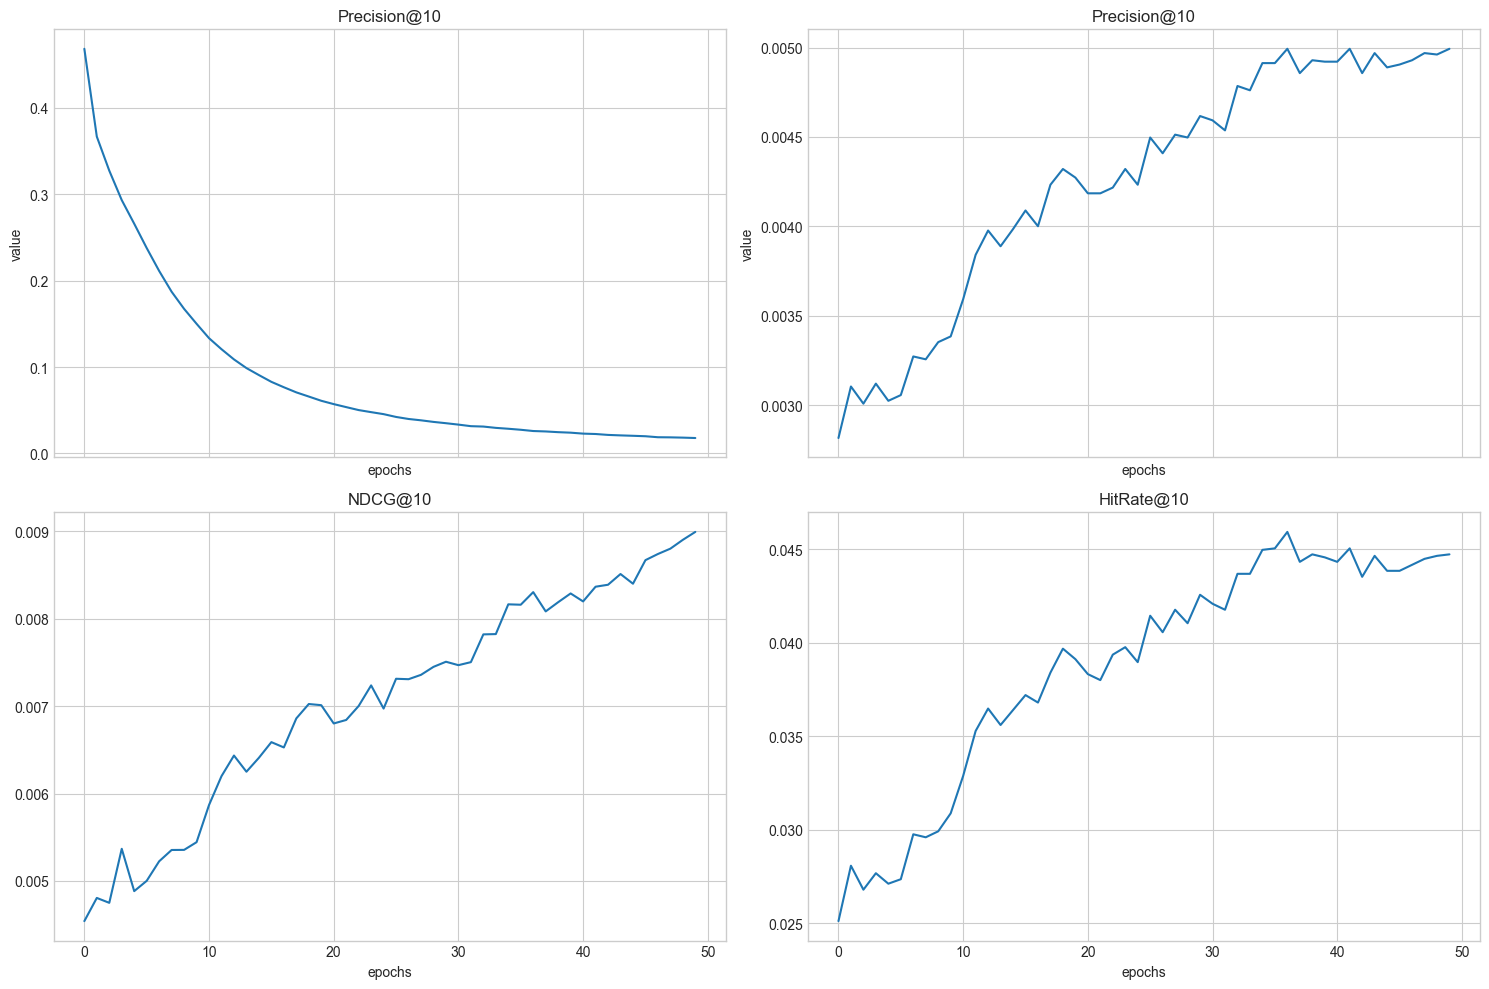

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [15]:
# Evaluate BPR - Ranking
all_results = {}
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Uniform'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0090
  Precision@10: 0.0050
  Hit Rate@10:  0.0447
  Users eval'd: 12497
  Time: 28.9s


### Popularity-based negatives sampling

In [16]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=50,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="pop",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/50 | train_bpr_loss=0.62031
Epoch 02/50 | train_bpr_loss=0.52263
Epoch 03/50 | train_bpr_loss=0.41743
Epoch 04/50 | train_bpr_loss=0.33104
Epoch 05/50 | train_bpr_loss=0.26793
Epoch 06/50 | train_bpr_loss=0.22122
Epoch 07/50 | train_bpr_loss=0.18482
Epoch 08/50 | train_bpr_loss=0.15735
Epoch 09/50 | train_bpr_loss=0.13757
Epoch 10/50 | train_bpr_loss=0.11957
Epoch 11/50 | train_bpr_loss=0.10585
Epoch 12/50 | train_bpr_loss=0.09521
Epoch 13/50 | train_bpr_loss=0.08634
Epoch 14/50 | train_bpr_loss=0.07800
Epoch 15/50 | train_bpr_loss=0.07201
Epoch 16/50 | train_bpr_loss=0.06604
Epoch 17/50 | train_bpr_loss=0.06128
Epoch 18/50 | train_bpr_loss=0.05658
Epoch 19/50 | train_bpr_loss=0.05344
Epoch 20/50 | train_bpr_loss=0.05018
Epoch 21/50 | train_bpr_loss=0.04708
Epoch 22/50 | train_bpr_loss=0.04467
Epoch 23/50 | train_bpr_loss=0.04201
Epoch 24/50 | train_bpr_loss=0.03994
Epoch 25/50 | train_bpr_loss=0.03815
Epoch 26/50 | train_bpr_loss=0.03594
Epoch 27/50 | train_bpr_loss=0.03441
E

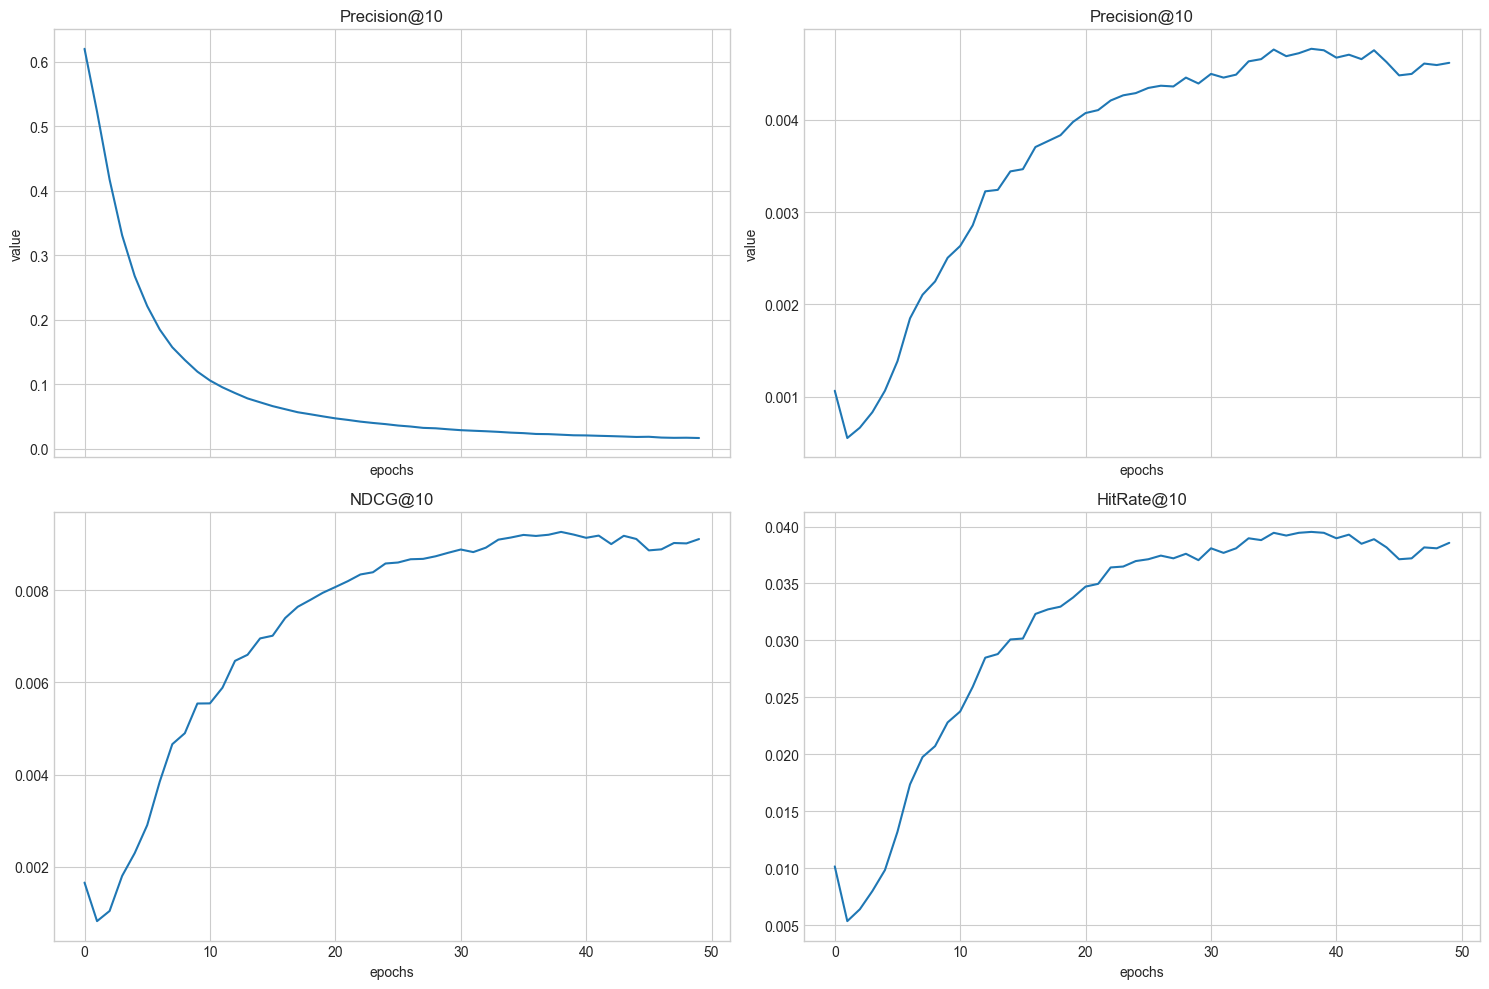

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [18]:
# Evaluate BPR - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Popularity'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0091
  Precision@10: 0.0046
  Hit Rate@10:  0.0386
  Users eval'd: 12497
  Time: 29.4s


### Mixed negatives sampling

In [19]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=50,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="mixed",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/50 | train_bpr_loss=0.57115
Epoch 02/50 | train_bpr_loss=0.48817
Epoch 03/50 | train_bpr_loss=0.42000
Epoch 04/50 | train_bpr_loss=0.35358
Epoch 05/50 | train_bpr_loss=0.29433
Epoch 06/50 | train_bpr_loss=0.24704
Epoch 07/50 | train_bpr_loss=0.20615
Epoch 08/50 | train_bpr_loss=0.17567
Epoch 09/50 | train_bpr_loss=0.15217
Epoch 10/50 | train_bpr_loss=0.13253
Epoch 11/50 | train_bpr_loss=0.11670
Epoch 12/50 | train_bpr_loss=0.10366
Epoch 13/50 | train_bpr_loss=0.09318
Epoch 14/50 | train_bpr_loss=0.08424
Epoch 15/50 | train_bpr_loss=0.07763
Epoch 16/50 | train_bpr_loss=0.07038
Epoch 17/50 | train_bpr_loss=0.06504
Epoch 18/50 | train_bpr_loss=0.05997
Epoch 19/50 | train_bpr_loss=0.05650
Epoch 20/50 | train_bpr_loss=0.05254
Epoch 21/50 | train_bpr_loss=0.04929
Epoch 22/50 | train_bpr_loss=0.04618
Epoch 23/50 | train_bpr_loss=0.04328
Epoch 24/50 | train_bpr_loss=0.04159
Epoch 25/50 | train_bpr_loss=0.03911
Epoch 26/50 | train_bpr_loss=0.03648
Epoch 27/50 | train_bpr_loss=0.03541
E

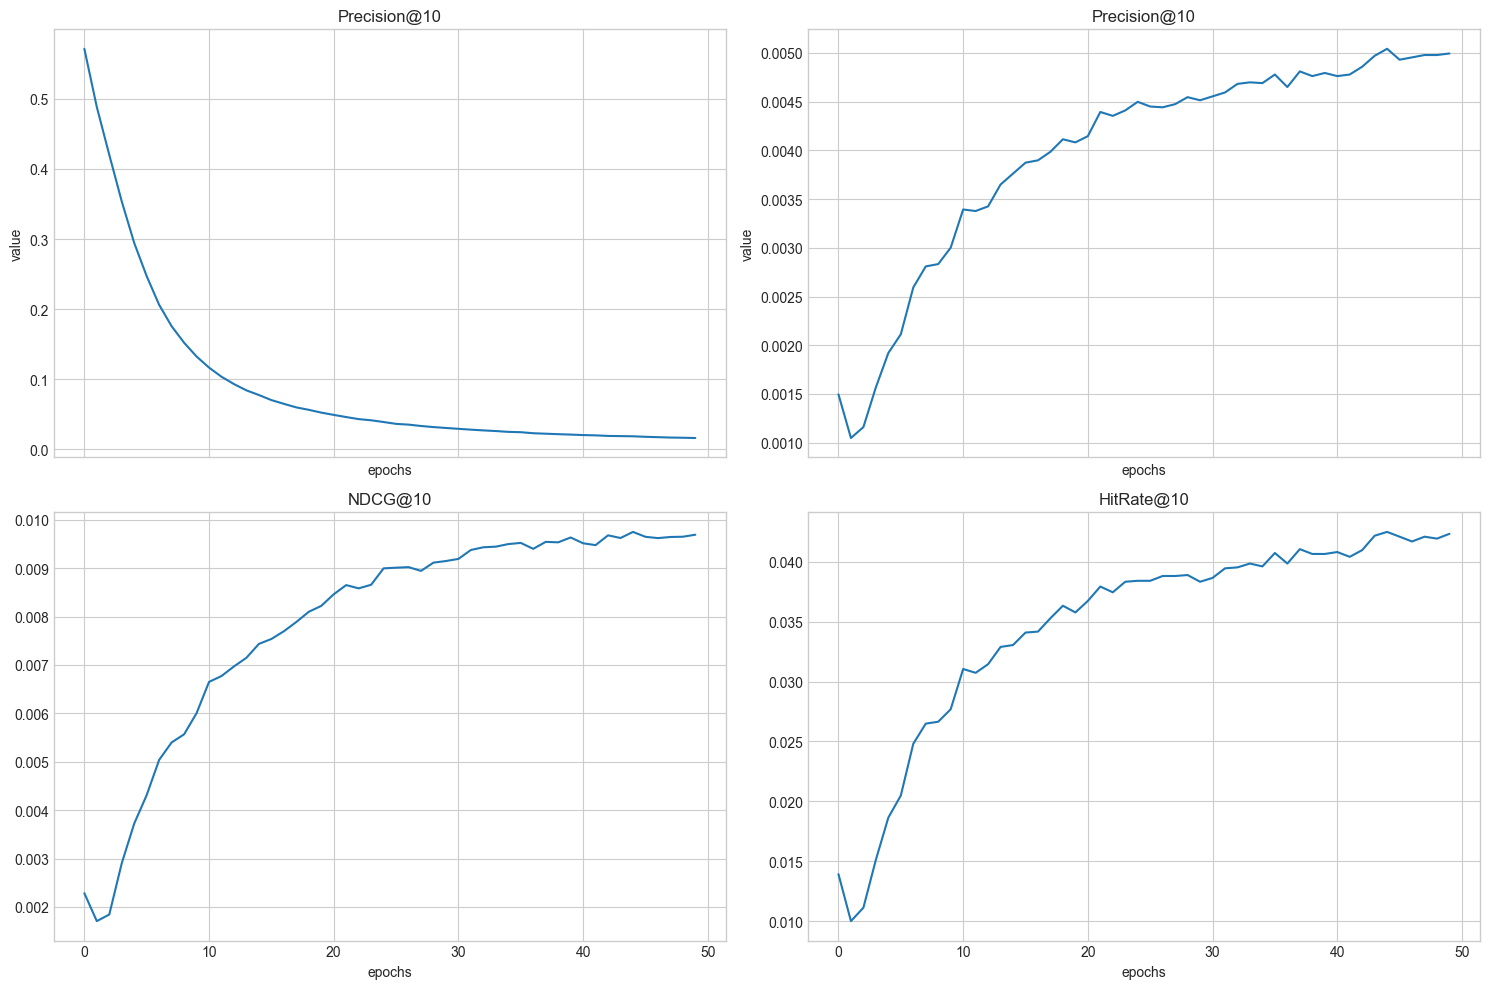

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [21]:
# Evaluate BPR - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Mixed'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0097
  Precision@10: 0.0050
  Hit Rate@10:  0.0423
  Users eval'd: 12497
  Time: 29.8s


In [22]:
all_results

{'Uniform': {'precision@10': np.float64(0.004993198367608226),
  'recall@10': np.float64(0.011942316284779205),
  'ndcg@10': np.float64(0.008994736835768942),
  'hit_rate@10': np.float64(0.04473073537649036),
  'map@10': np.float64(0.004082381064321186),
  'mrr@10': np.float64(0.014972514038289824),
  'catalog_coverage@10': 0.15716364598491864,
  'users_evaluated': 12497,
  'user_coverage': 1.0},
 'Popularity': {'precision@10': np.float64(0.004617108105945427),
  'recall@10': np.float64(0.009354508059230127),
  'ndcg@10': np.float64(0.009107627967261793),
  'hit_rate@10': np.float64(0.03856925662158918),
  'map@10': np.float64(0.004776889530135333),
  'mrr@10': np.float64(0.017231024334729225),
  'catalog_coverage@10': 0.6639767164968912,
  'users_evaluated': 12497,
  'user_coverage': 1.0},
 'Mixed': {'precision@10': np.float64(0.004993198367608227),
  'recall@10': np.float64(0.010718785492975481),
  'ndcg@10': np.float64(0.009690638619681847),
  'hit_rate@10': np.float64(0.04233015923

## 3. Results comparison

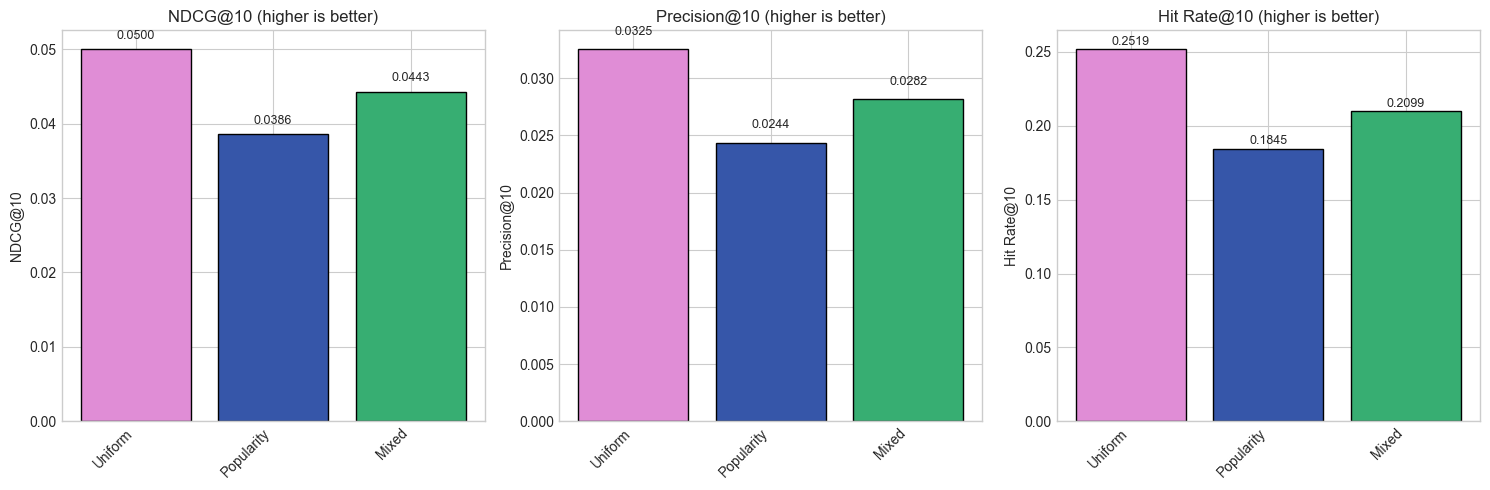

In [34]:
# Visualize ranking metrics (only models that have ranking results)
model_order = ['Uniform', 'Popularity', 'Mixed']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
ranking_colors = []
for m in model_order:
    if 'Uniform' in m:
        ranking_colors.append("#e08dd6")
    elif 'Popularity' in m:
        ranking_colors.append("#3656A9")
    elif 'Mixed' in m:
        ranking_colors.append("#37AE72")


for idx, (metric, title) in enumerate([
    ('ndcg@10', 'NDCG@10'),
    ('precision@10', 'Precision@10'),
    ('hit_rate@10', 'Hit Rate@10')
]):
    ax = axes[idx]
    vals = [all_results[m].get(metric, 0) for m in model_order]
    bars = ax.bar(range(len(model_order)), vals, color=ranking_colors, edgecolor='black')
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=45, ha='right')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (higher is better)')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
